In [1]:
"""
Created By    : Taylor McHone
Creation Date : 28 September 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting.
Used a second order, two-dimensional polynomial fitting technique and solved for the expansion coefficient that
minimized the difference between the analysis polynomial and 500 mb height observations.

"""
__author__    = "Taylor McHone"
__contact__   = "taylor.mchone@und.edu"

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import pandas as pd

In [124]:
### Read in observations ###
df = pd.read_csv("RAOBs_201903131200.txt", sep=",", names=['station', 'lat', 'lon', 'height', 'wind_direction', 'wind_speed'])

#convert lat/lon to radians and add to df
df['lat_radians']=df['lat']*(np.pi/180)
df['lon_radians']=df['lon']*(np.pi/180)
df.head()

,station,lat,lon,height,wind_direction,wind_speed,lat_radians,lon_radians
0,CWPL,51.47,-90.2,5460.0,285.0,29.0,0.898321,-1.574287
1,CWQI,43.83,-66.0,5540.0,325.0,41.0,0.764978,-1.151917
2,CWSE,53.55,-113.9,5360.0,280.0,12.0,0.934624,-1.987930
3,CYAH,53.75,-73.6,5340.0,300.0,70.0,0.938114,-1.284562
4,CYBK,64.30,-96.0,5220.0,95.0,17.0,1.122247,-1.675516


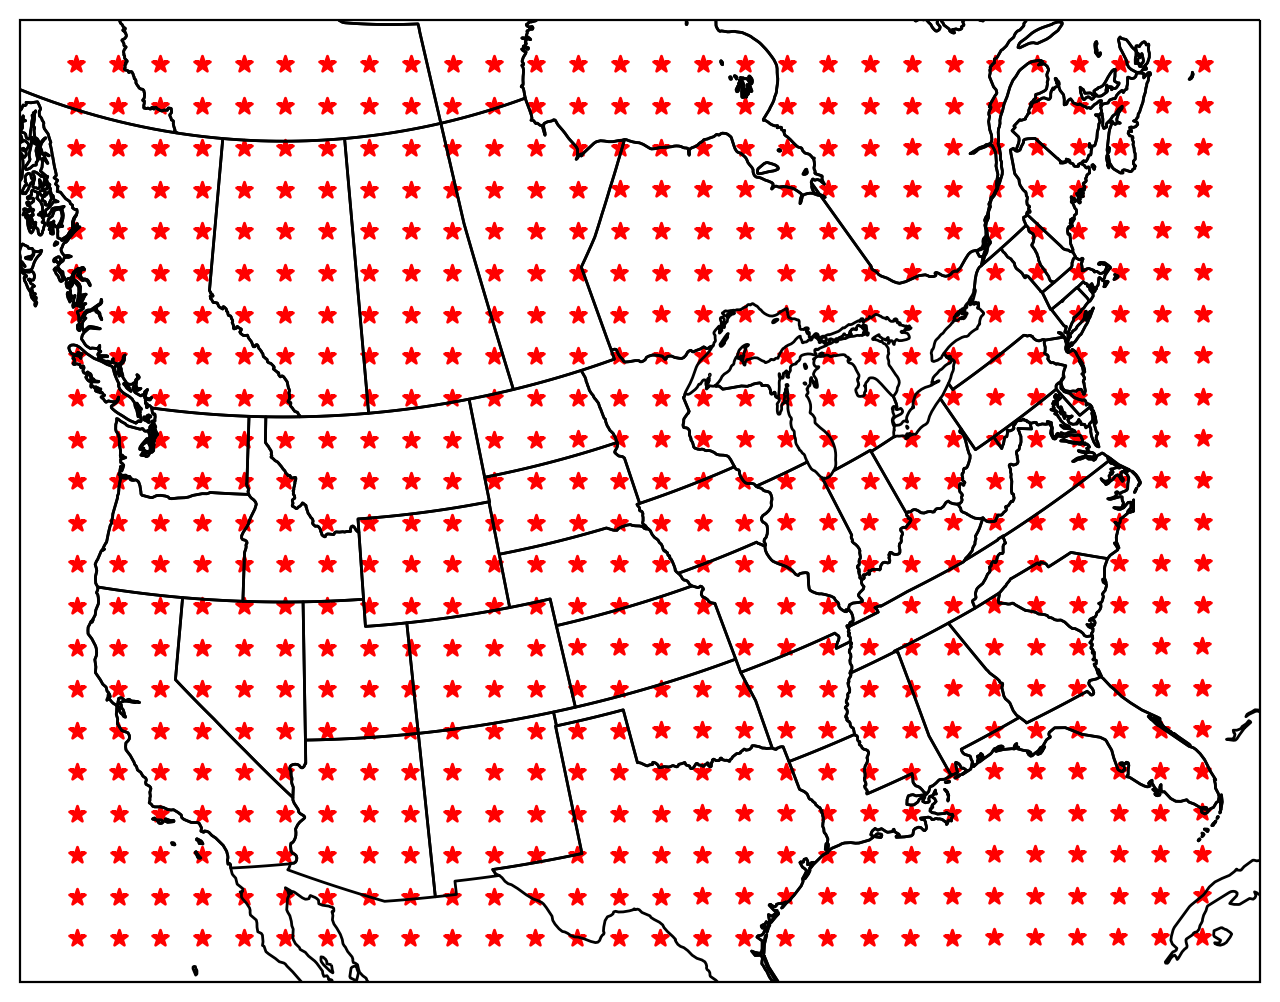

In [125]:
### Set up analysis map with a 22x28 rectangular grid of points ###

#find grid points
x_step = 18.9 + np.arange(22)*1.27 #18.9,-6.3 starting pts, 22,28 number of axis pts, 1.27cm between pts
y_step = -6.3 + np.arange(28)*1.27
xx,yy = np.meshgrid(x_step,y_step)

#convert grid points to lat/lon

#known vals
map_proj=1/(15e6)
rho = 6371 * 1e5
lambda_o=-115
phi_o = 60 * (np.pi/180)

#transformation eqs
x2lon = np.arctan(yy/xx) * (180/np.pi) + lambda_o
y2lat = (180/np.pi) * ((np.pi/2) - (2*np.arctan(np.sqrt((xx/map_proj)**2+(yy/map_proj)**2)/(rho*(1+np.sin(phi_o))))))

#plot to verify
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

ax1.scatter(x2lon, y2lat, transform=ccrs.PlateCarree(), marker='*', color='red')


In [126]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###

#assign vars
phi = df['lat_radians']
lambdy = df['lon_radians']

#solve for image scale factor and radius of lat circle
sigma = (1+np.sin(phi_o))/(1+np.sin(phi))
r = rho * sigma * np.cos(phi) * map_proj

#lam = deviation of lon from standard lon
lam = lambdy - (lambda_o*np.pi/180)
x = r*np.cos(lam)#*map_proj
y = r*np.sin(lam)#*map_proj

df['x_vals']=x
df['y_vals']=y

In [127]:
df.head()

,station,lat,lon,height,wind_direction,wind_speed,lat_radians,lon_radians,x_vals,y_vals
0,CWPL,51.47,-90.2,5460.0,285.0,29.0,0.898321,-1.574287,25.146187,11.619170
1,CWQI,43.83,-66.0,5540.0,325.0,41.0,0.764978,-1.151917,22.162437,25.494968
2,CWSE,53.55,-113.9,5360.0,280.0,12.0,0.934624,-1.987930,26.091668,0.500986
3,CYAH,53.75,-73.6,5340.0,300.0,70.0,0.938114,-1.284562,19.460312,17.156573
4,CYBK,64.30,-96.0,5220.0,95.0,17.0,1.122247,-1.675516,17.094354,5.886058


In [135]:
#radius of influence in cm
rois = np.array([10,20])

#empty matrices
obs_mx = np.zeros((28, 22, len(rois)))
analysis_mx = np.zeros((28, 22, len(rois)))


#make sure obs are in a certain radius

for i in range(len(rois)):
    roi_current = rois[i]
    for j in range(len(xx)): 
        for k in range(len(xx[j])):
            xd = xx[j,k] - x # grid point loc minus observation loc
            yd= yy[j,k] - y

            #distance formula
            radius = ((xd**2 + yd**2)**.5)
            
            #array containing radius (above) where observation is in region of influence
            idx_rois = np.where(radius<= roi_current)[0]  
            #counting number of obs a grid point has
            obs_mx[j,k,i] = len(idx_rois)  
            
            #get x_k, y_k and height (fo) to be used in big mx equations
            x_k = xd[idx_rois]
            y_k = yd[idx_rois]
            fo = np.array(df['height'][idx_rois]) 
            
            #the x_k,y_k mx
            R = np.zeros((6,6))
            #the obs mx
            O = np.zeros(6)
            
            for idx in range(len(y_k)):
                xyk = np.matrix([[1, x_k.iloc[idx], y_k.iloc[idx], x_k.iloc[idx]**2, y_k.iloc[idx]**2, x_k.iloc[idx]*y_k.iloc[idx]]])
                xykT = xyk.T #transpose
                
                r= xykT*xyk #mult  transpose and reg to get big kahuna mx
                R+=np.array(r) 
                
                
                #heights heights heights
                O += np.array([fo[idx], fo[idx]*x_k.iloc[idx], fo[idx]*y_k.iloc[idx], fo[idx]*x_k.iloc[idx]**2, fo[idx]*y_k.iloc[idx]**2, fo[idx]*y_k.iloc[idx]*x_k.iloc[idx]])
            O = O / obs_mx[j,k,i] #average outside of for loop- when all calcs done
            R = R / obs_mx[j,k,i] #average
            
                
                
            #c is value of height at grid point
            #c = R inverse * O
            c = np.linalg.inv(np.matrix(R))*np.matrix(O).T
            analysis_mx[j,k,i]=c[0,0] #save coo to analysis mx
                

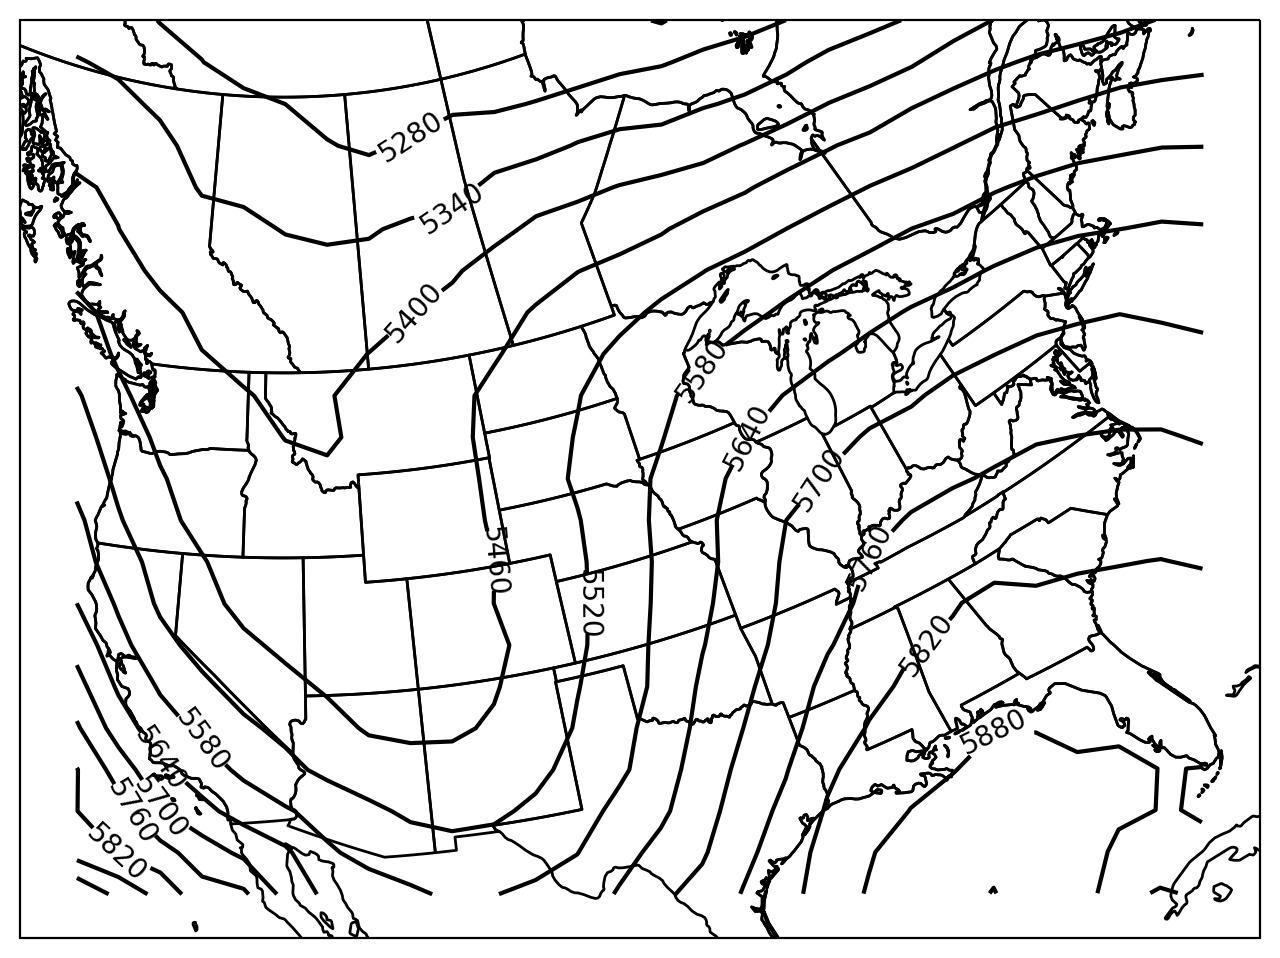

In [141]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#
#roi 10cm

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(x2lon,y2lat,analysis_mx[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))

plt.show()
#ax1.contour(LON,LAT,ANALYSIS[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())


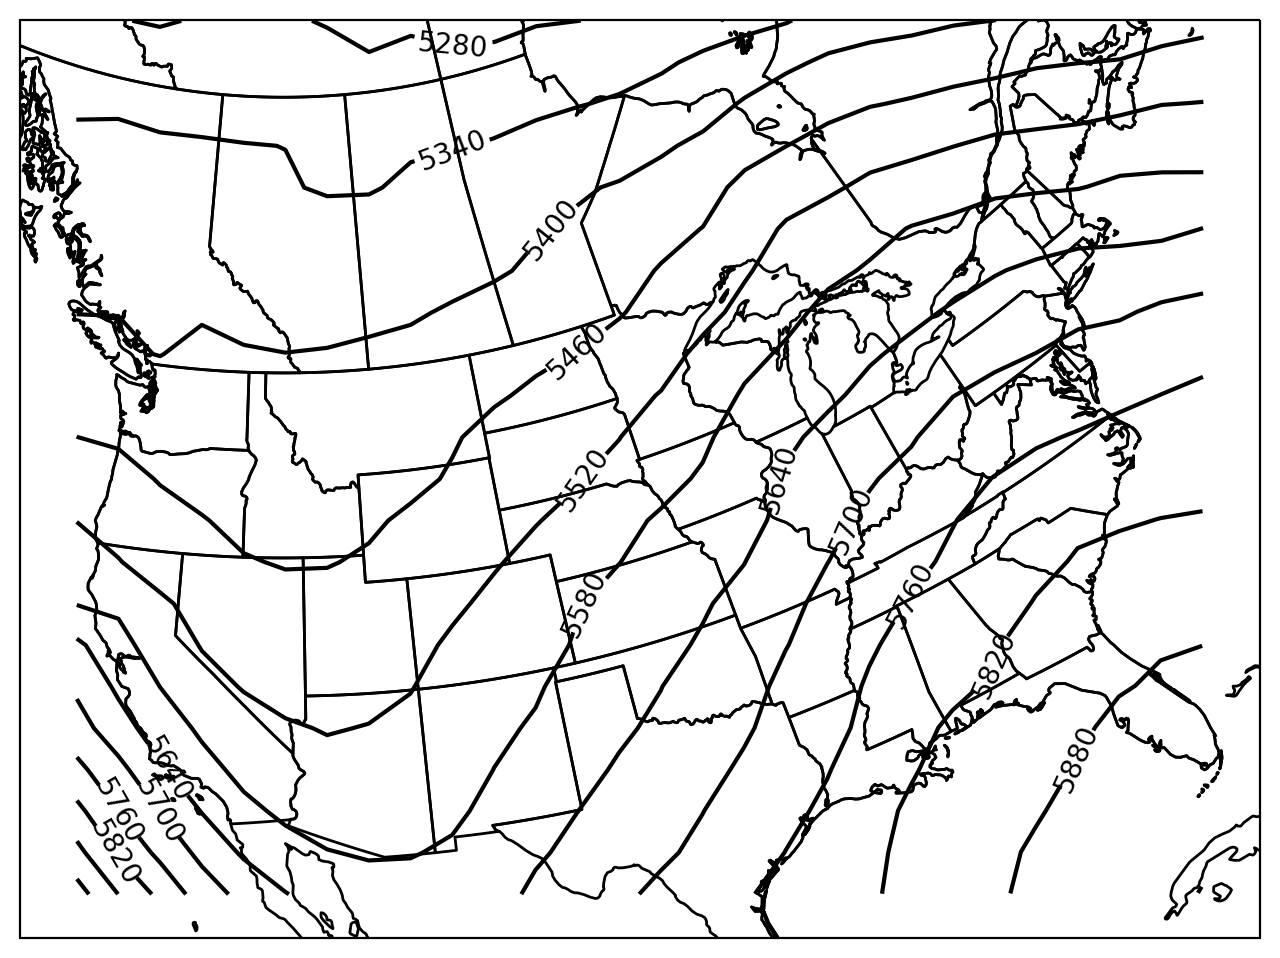

In [142]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#
#roi 20cm

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(x2lon,y2lat,analysis_mx[:,:,1],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))

plt.show()


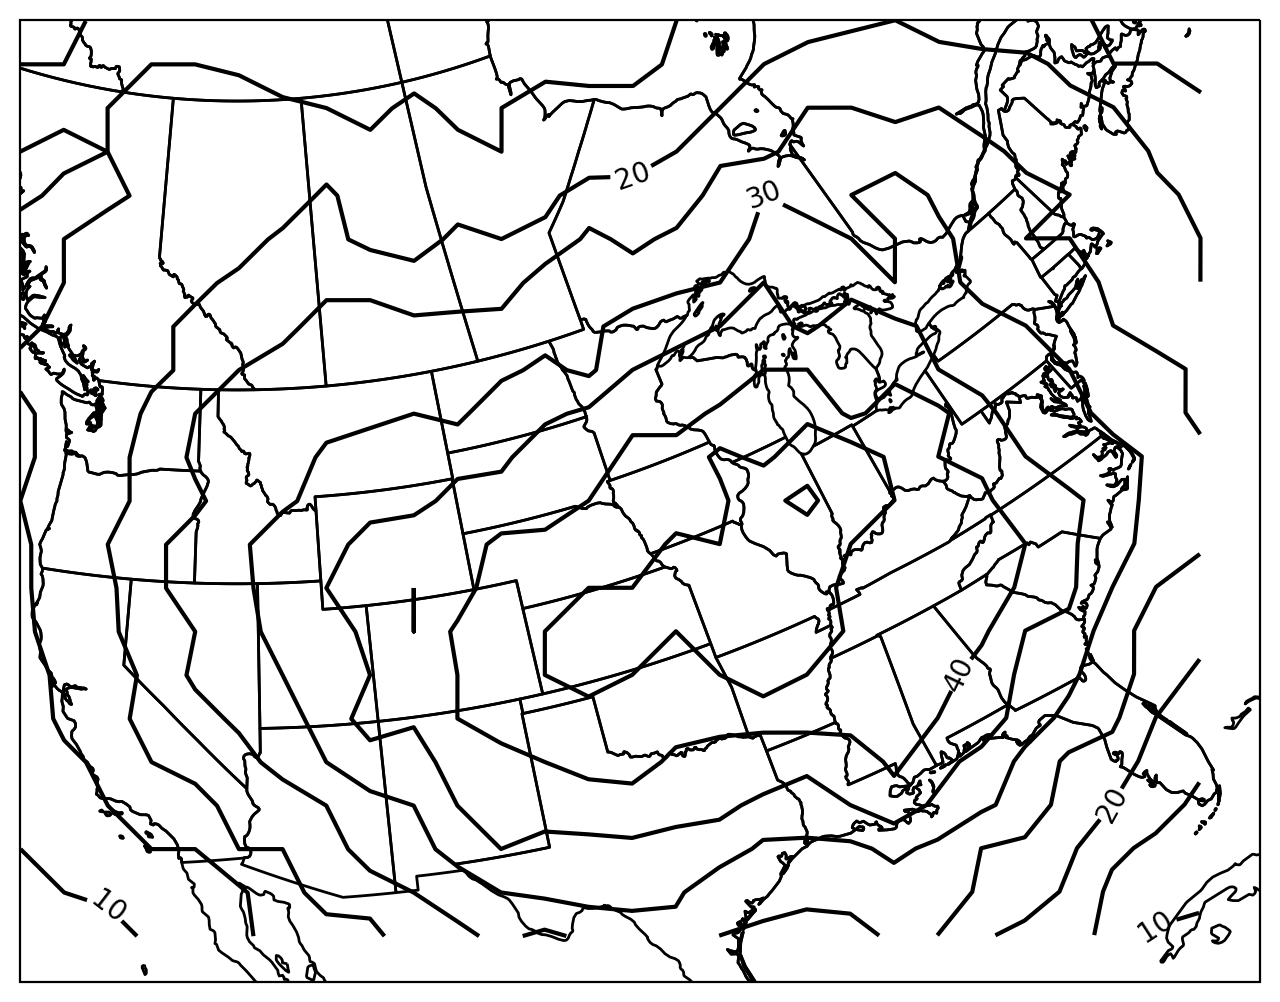

In [143]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
#for roi=10cm
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(x2lon,y2lat,obs_mx[:,:,0],colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))

plt.show()


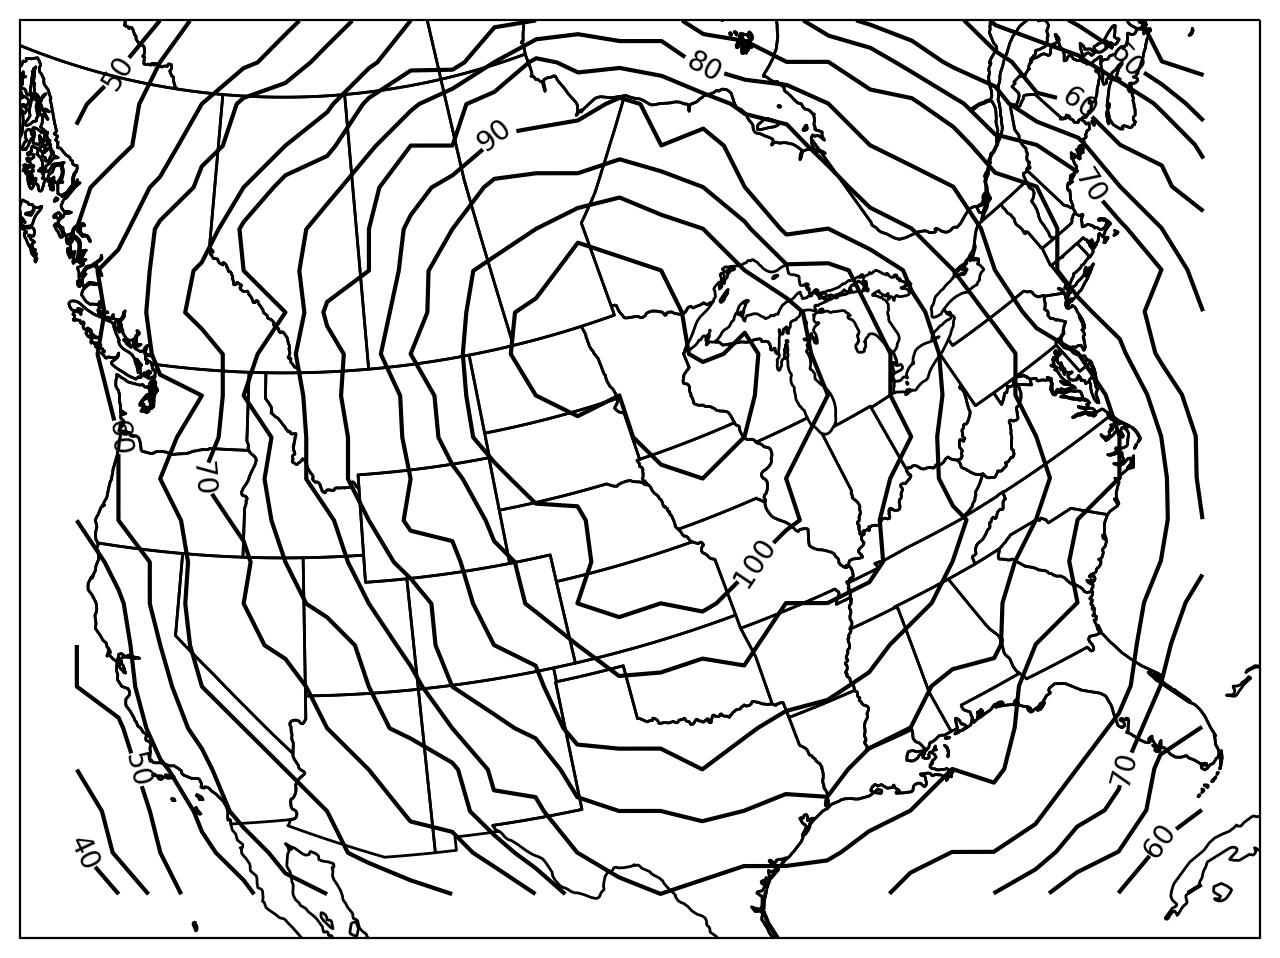

In [144]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
#for roi=20cm
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(x2lon,y2lat,obs_mx[:,:,1],colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))
plt.show()


In [113]:
### Store the analyses in text files ###
"""
a_file = open("analysis_vals.txt", "w") #shape
for row in analysis_mx:
    np.savetxt(a_file, row)

a_file.close()
"""""

In [121]:
#np.loadtxt("analysis_vals.txt").reshape(28, 22, 2)

In [120]:
### Store the number of observations available for each grid point in text files ###
""""
a_file = open("observation_count.txt", "w")
for row in obs_mx:
    np.savetxt(a_file, row)

a_file.close()
""""

In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.

    Both plots contain a trough in the west with lower heights and a ridge in the southeast with higher heights. 
    

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    
    The analysis with ROI of 20cm seems smoother than the analysis with ROI of 10cm. Its lines are also
    spaced farther apart. A larger radius of influence (20 cm) means there are more observations available to each grid point. 
    Similarly, a smaller radius (10 cm) means fewer observations are available. So smaller scale features are more visible on 
    the plot with ROI of 10 cm and the lines appear choppier.
    

3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?
    
    The results do not look realistic - the lines are thicker and overlapping near the border of the plot.
    This could be from a lack of observations in these areas due to the reduced radius of influence.

4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?
    
    No, this program cannot run with only one observation available to each grid point. Without multiple observations,
    all x_k's are the same and all y_k's are the same. This makes the determinant of the matrix zero and 
    results in a non-invertible matrix.
    
    

'''